In [1]:
import src
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

td = src.preproc.load_data()


(<Figure size 600x400 with 2 Axes>,
 array([<Axes: xlabel='time from grasp1', ylabel="('motor', 91)">,
        <Axes: xlabel='time from release1', ylabel="('motor', 91)">],
       dtype=object))

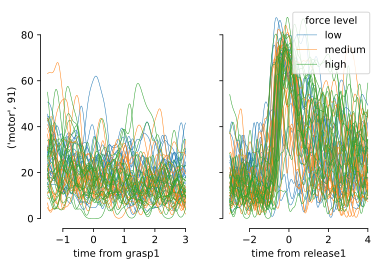

In [2]:
src.plot.plot_step_psth(td,('motor',91),single_trial=True)


/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state')
/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:106: RuntimeWarning: Mean of empty slice
  .agg(lambda s: np.nanmean(s,axis=0))


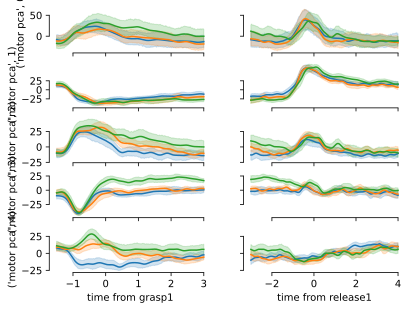

In [53]:
# z-scoring and softnorming seem to give very different results on PC space
step_grasp_data,step_release_data = (
    td
    .pipe(src.preproc.norm_and_shift_rates,norm_method='softnorm')
    .pipe(src.plot.run_step_pca,which_area='motor')
    .pipe(src.preproc.get_step_grasp_release_data)
)

num_comps=5
fig,axs = plt.subplots(num_comps,2,sharex='col',sharey='row')
for compnum in range(num_comps):
    src.plot.plot_step_signal(
        step_grasp_data,
        step_release_data,
        ('motor pca',compnum),
        axs=axs[compnum,:],
        add_legend=False,
        single_trial=False,
    )


/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state')
/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:106: RuntimeWarning: Mean of empty slice
  .agg(lambda s: np.nanmean(s,axis=0))


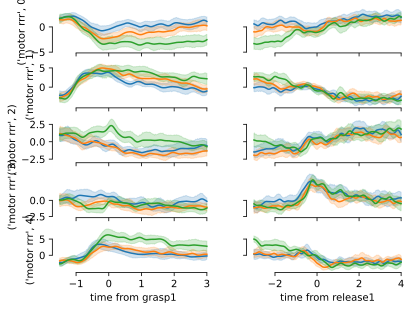

In [55]:
# z-scoring and softnorming seem to give very different results on PC space
step_grasp_data,step_release_data = (
    td
    .pipe(src.preproc.norm_and_shift_rates,norm_method='softnorm')
    .pipe(src.plot.run_step_rrr,rank=5)
    .pipe(src.preproc.get_step_grasp_release_data)
)

num_comps=5
fig,axs = plt.subplots(num_comps,2,sharex='col',sharey='row')
for compnum in range(num_comps):
    src.plot.plot_step_signal(
        step_grasp_data,
        step_release_data,
        ('motor rrr',compnum),
        axs=axs[compnum,:],
        add_legend=False,
        single_trial=False,
    )


In [ ]:
step_ramp_data = (
    pd.concat([
        td_shifted.groupby('trial type').get_group(g)
        for g in ['step']
    ])
)
event_times = src.events.get_state_transition_times(step_ramp_data['state'])
grasp_times = event_times.loc[(slice(None),slice(None),'grasp1')]
release_times = event_times.loc[(slice(None),slice(None),'release1')]
hold_lens = release_times-grasp_times
sns.histplot(hold_lens.dt.total_seconds())

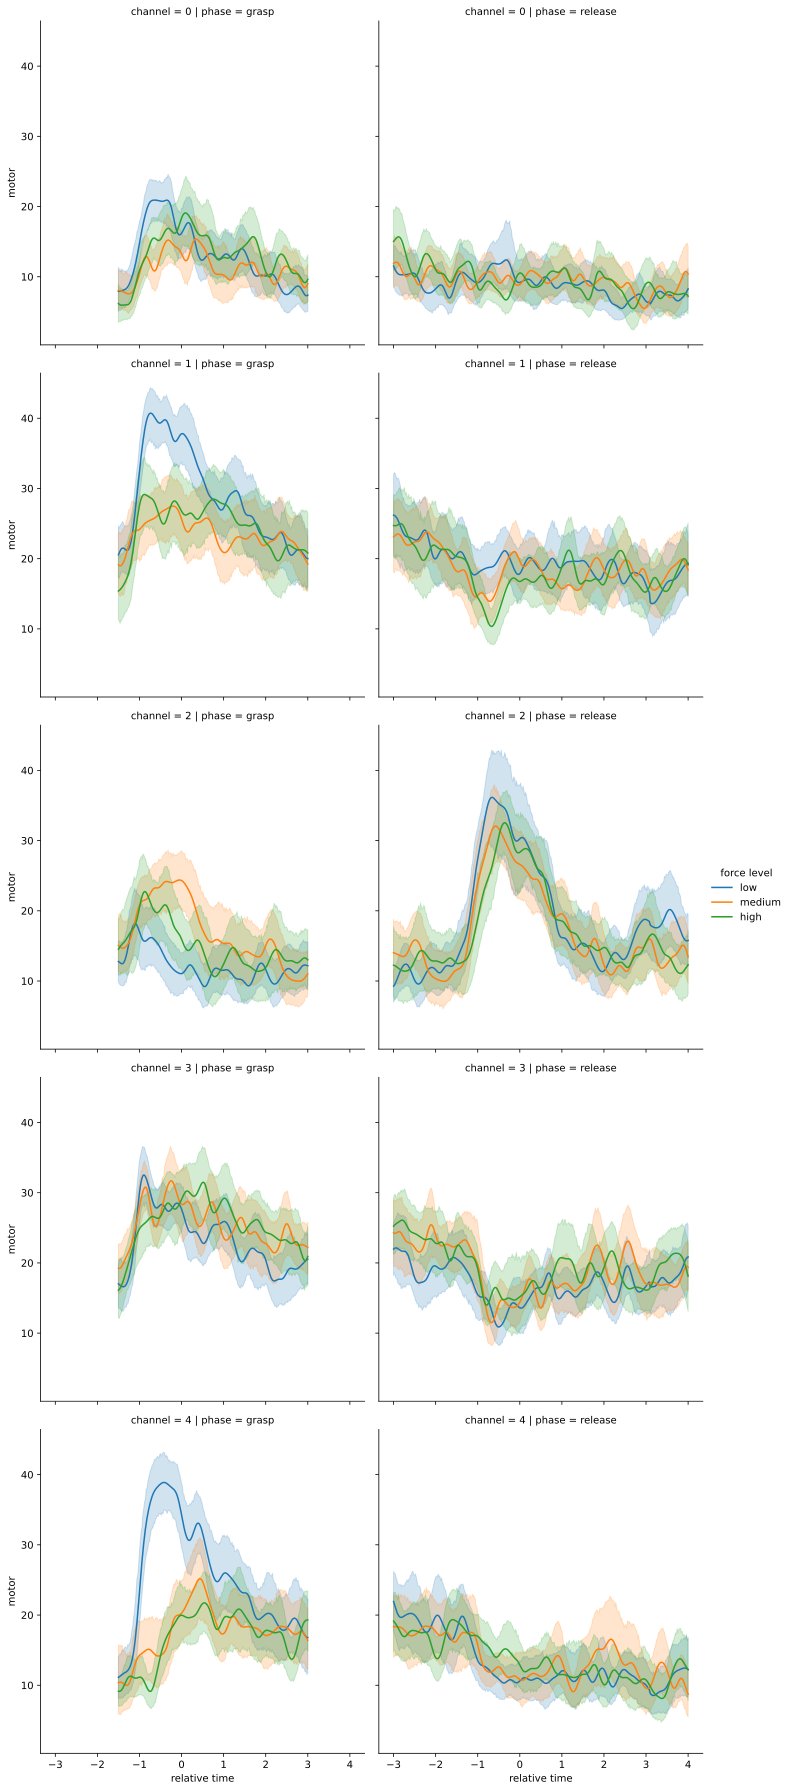

In [90]:
temp = src.munge.get_step_grasp_release_data(td_shifted)
new_temp = (
    temp
    .drop(columns=[('trial_time',''),('state','')])
    .set_index(['trial type','force level','force'],append=True)
    .stack()
    .reset_index(level=-1)
    .rename(columns={'level_7':'channel'})
    .set_index('channel',append=True)
)
idx = pd.IndexSlice
sns.relplot(
    data=new_temp.loc[idx[:,:,:,:,:,:,:,range(5)],:],
    x='relative time',
    y='motor',
    hue='force level',
    hue_order=['low','medium','high'],
    kind='line',
    col='phase',
    row='channel',
)

In [74]:
temp.shape

(34620, 261)

In [76]:
34620*192

6647040